In [1]:
import os
from metient.util import plotting_util as putil
from metient.util import eval_util as eutil

import pandas as pd
import fnmatch
import seaborn as sns

REPO_DIR = os.path.join(os.getcwd(), "../../")

In [2]:
SITES = ["m5", "m8"]
MIG_TYPES = ["mS", "M", "S", "R"]
CUTOFF = 1.0
k = float("inf")
LOSS_THRES=0.0
SUFFIX='_calibrate'

DATE = "06092024"
PARAMS = "calibrate_wip_solvepoly_fixedinit_lessreg"

tot 1647
29


<Axes: xlabel='clusters', ylabel='Count'>

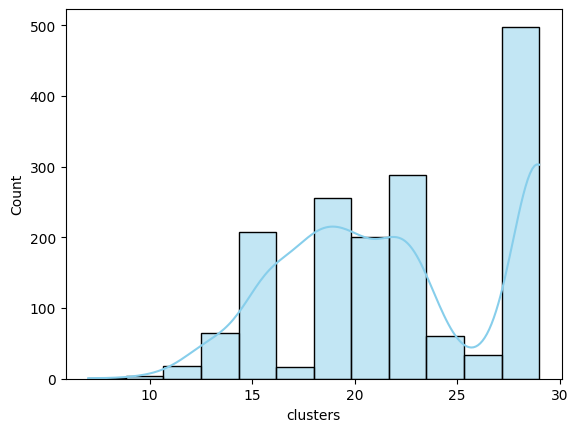

In [3]:

# Get number of clusters (tree vertices to label) per site/mig_type/seed combo
def get_num_mut_trees(mut_tree_fn):
    with open(mut_tree_fn, 'r') as f:
        # look for line w/ "3 #trees" as an example
        for line in f:
            if  "#trees" in line:
                return int(line.strip().split()[0])
sims_dir = os.path.join(REPO_DIR, "data/machina_sims")
og_sims_dir = "/data/morrisq/divyak/projects/machina/data/sims"

data = []
tot = 0
for site in SITES:
    for mig_type in MIG_TYPES:
        site_mig_type_dir = os.path.join(sims_dir, site, mig_type)
        seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
        seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
        for seed in seeds:
            fn = os.path.join(site_mig_type_dir, f"clustering_observed_seed{seed}.txt")
            num_lines = sum(1 for _ in open(fn))
            fn = os.path.join(og_sims_dir, site, mig_type,f"T_seed{seed}.labeling")
            sites = set()
            with open(fn) as f:
                for line in f:
                    sites.add(line.strip().split()[1])
            n = get_num_mut_trees(os.path.join(sims_dir, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt"))
            #print(n)
            tot+=n
            for i in range(n):
                data.append([seed, site, mig_type, num_lines, len(sites), i])
print("tot",tot)
cols = ["seed", "site", "mig_type", "clusters", "sites", "tree_num"]
cluster_num_df = pd.DataFrame(data, columns=cols)
cluster_num_df["seed"] = cluster_num_df["seed"].astype(int)
print(cluster_num_df['clusters'].max())

cluster_num_df['cluster_bins'] = pd.qcut(cluster_num_df['clusters'], 3, labels=False, duplicates='drop')
denom=10000
def calc_prob_size(num_sites, num_nodes):
    return (num_sites**(num_nodes-1))
cluster_num_df['prob_size'] = cluster_num_df.apply(lambda row: calc_prob_size(row["sites"], row['clusters'])/denom, axis=1)
cluster_num_df['prob_size_bins'] = pd.qcut(cluster_num_df['prob_size'], 3, labels=False, duplicates='drop')

sns.histplot(cluster_num_df['clusters'], kde=True, color='skyblue')


In [4]:
cluster_num_df

,seed,site,mig_type,clusters,sites,tree_num,cluster_bins,prob_size,prob_size_bins
0,0,m5,mS,19,5,0,0,"381,469,726.562",0
1,0,m5,mS,19,5,1,0,"381,469,726.562",0
2,7,m5,mS,14,5,0,0,"122,070.312",0
3,7,m5,mS,14,5,1,0,"122,070.312",0
4,4,m5,mS,12,5,0,0,"4,882.812",0
...,...,...,...,...,...,...,...,...,...
1642,157,m8,R,29,11,43,2,"14,420,993,610,649,923,169,026,048.000",2
1643,157,m8,R,29,11,44,2,"14,420,993,610,649,923,169,026,048.000",2
1644,157,m8,R,29,11,45,2,"14,420,993,610,649,923,169,026,048.000",2
1645,157,m8,R,29,11,46,2,"14,420,993,610,649,923,169,026,048.000",2


### Evaluate Metient's best trees based on batch size, tree size and number of anatomical sites

In [5]:
from tqdm import tqdm
import re

batch_sizes = ['64', '256', '1024', ]
num_runs = 5

metient_results_dir = '/data/morrisq/divyak/data/metient_prediction_results/'


bs_to_num_nodes_to_ground_truth_slns = {bs:{} for bs in batch_sizes}
bs_to_num_sites_to_ground_truth_slns = {bs:{} for bs in batch_sizes}
bs_to_prob_size_bin_to_ground_truth_slns = {bs:{} for bs in batch_sizes}
bs_to_prob_size_to_ground_truth_slns = {bs:{} for bs in batch_sizes}

for bs in batch_sizes:
    for run in range(1,num_runs+1):
        prediction_dir = os.path.join(metient_results_dir, f'predictions_batch_exp_bs{bs}_{PARAMS}_r{run}_{DATE}')

        print(prediction_dir)
        grad_m5_f1_scores = []
        grad_m8_f1_scores = []
        ct = 0
        tot = 0
        for site in SITES:
            for mig_type in tqdm(MIG_TYPES):
                true_site_mig_type_data_dir = os.path.join(og_sims_dir, site, mig_type)
                seeds = fnmatch.filter(os.listdir(true_site_mig_type_data_dir), 'clustering_observed_seed*.txt')
                seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
                predicted_site_mig_type_data_dir = os.path.join(prediction_dir, site, mig_type)
                print(seeds)
                print(predicted_site_mig_type_data_dir)
                for seed in seeds:
                    tree_info = eutil.get_metient_min_loss_trees(predicted_site_mig_type_data_dir, seed, k, loss_thres=LOSS_THRES, suffix=SUFFIX)
                    ground_truth_clones_found = False
                    ground_truth_mig_graph_found = False
                    Fs, F_G2s = [], []

                    for i, (loss, met_results_dict, met_tree_num) in enumerate(tree_info):
                        print(bs, site, mig_type, seed, met_tree_num)
                        recall, precision, F, has_resolved_polytomy = eutil.evaluate_seeding_clones(os.path.join(true_site_mig_type_data_dir, f"T_seed{seed}.tree"),
                                                                      os.path.join(true_site_mig_type_data_dir, f"T_seed{seed}.vertex.labeling"),
                                                                      met_results_dict, met_tree_num)
                        print(recall, precision, F)

                        if F >= CUTOFF:
                            ground_truth_clones_found = True

                        recall_G2, precision_G2, F_G2 = eutil.evaluate_migration_multigraph(os.path.join(true_site_mig_type_data_dir, f"G_seed{seed}.tree"),
                                                                                            met_results_dict, met_tree_num)
                        if F_G2 >= CUTOFF:
                            ground_truth_mig_graph_found = True   
                        Fs.append(F)
                        F_G2s.append(F_G2)
                    subset_df = cluster_num_df[(cluster_num_df['seed']==int(seed))&(cluster_num_df['site']==site)&(cluster_num_df['mig_type']==mig_type)]
                    num_nodes = subset_df.iloc[0]['clusters']
                    rng = subset_df['cluster_bins'].unique().item()
                    if rng not in bs_to_num_nodes_to_ground_truth_slns[bs]:
                        bs_to_num_nodes_to_ground_truth_slns[bs][rng] = []
                    if sum(Fs)/len(Fs) < min(Fs):
                        ct += 1
                    tot+= 1
                    info = (ground_truth_clones_found, ground_truth_mig_graph_found, sum(Fs)/len(Fs), sum(F_G2s)/len(F_G2s))
                    bs_to_num_nodes_to_ground_truth_slns[bs][rng].append(info)

                    num_sites = subset_df.iloc[0]['sites']
                    if num_sites not in bs_to_num_sites_to_ground_truth_slns[bs]:
                        bs_to_num_sites_to_ground_truth_slns[bs][num_sites] = []
                    bs_to_num_sites_to_ground_truth_slns[bs][num_sites].append(info)
                    
                    prob_size_bin = subset_df['prob_size_bins'].unique().item()
                    if prob_size_bin not in bs_to_prob_size_bin_to_ground_truth_slns[bs]:
                        bs_to_prob_size_bin_to_ground_truth_slns[bs][prob_size_bin] = []
                    bs_to_prob_size_bin_to_ground_truth_slns[bs][prob_size_bin].append(info)
                    
                    prob_size = subset_df['prob_size'].unique().item()
                    if prob_size not in bs_to_prob_size_to_ground_truth_slns[bs]:
                        bs_to_prob_size_to_ground_truth_slns[bs][prob_size] = []
                    bs_to_prob_size_to_ground_truth_slns[bs][prob_size].append(info)

bs_to_prob_size_bin_to_ground_truth_slns


  0%|          | 0/4 [00:00<?, ?it/s]

/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m5/mS
# min loss trees: 1
64 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 2
64 m5 mS 12 0
1.0 1.0 1.0
64 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixed

 50%|█████     | 2/4 [00:01<00:01,  1.17it/s]

# min loss trees: 1
64 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m5/S
# min loss trees: 1
64 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 31 0
0.6666666666666666 1.0 0.8


 75%|███████▌  | 3/4 [00:02<00:00,  1.38it/s]

# min loss trees: 1
64 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714
# min loss trees: 1
64 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m5/R
# min loss trees: 1
64 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 R 981 0
0.6 1.0 0.7499999999999999
# min loss trees: 1
64 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 2
64 m5 R 950 0
0.8 1.0 0.8888888888888888
64 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 R 955

  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
64 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/mS
# min loss trees: 1
64 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
64 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:03<00:09,  3.13s/it]

# min loss trees: 2
64 m8 mS 12 0
1.0 1.0 1.0
64 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/M
# min loss trees: 1
64 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
64 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
64 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:08<00:07,  3.77s/it]

# min loss trees: 1
64 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 241 0
1.0 0.8333333333333334 0.9090909090909091
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/S
# min loss trees: 1
64 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 31 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
64 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 54 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:18<00:05,  5.74s/it]

# min loss trees: 1
64 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/R
# min loss trees: 1
64 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
64 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
64 m8 R 905 0
0.8333333333333334 0.8333333333333334 0.8333333333333334
# min loss trees: 1
64 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
64 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 981 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
64 m8 R 30342 0
0.6666666666666666 1.0 0.8


 25%|██▌       | 1/4 [00:00<00:00,  9.43it/s]

# min loss trees: 1
64 m8 R 157 0
1.0 1.0 1.0
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m5/mS
# min loss trees: 1
64 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate

 50%|█████     | 2/4 [00:00<00:00,  2.96it/s]

# min loss trees: 1
64 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m5/S
# min loss trees: 1
64 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 31 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714


 75%|███████▌  | 3/4 [00:01<00:00,  3.23it/s]

# min loss trees: 1
64 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m5/R
# min loss trees: 1
64 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 R 981 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 R 955 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 518 0
0.75 1.0 0.8571428571428572


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
64 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/mS
# min loss trees: 1
64 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 2
64 m8 mS 4 0
0.6 0.75 0.6666666666666666
64 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
64 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:02<00:08,  2.90s/it]

# min loss trees: 1
64 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/M
# min loss trees: 1
64 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 2
64 m8 M 216 0
1.0 1.0 1.0
64 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
64 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:07<00:07,  3.51s/it]

# min loss trees: 1
64 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 241 0
1.0 1.0 1.0
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/S
# min loss trees: 1
64 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 31 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 54 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:18<00:05,  5.69s/it]

# min loss trees: 1
64 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/R
# min loss trees: 2
64 m8 R 10157 0
1.0 1.0 1.0
64 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
64 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
64 m8 R 905 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
64 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
64 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
64 m8 R 30342 0
0.6666666666666666 1.0 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
64 m8 R 157 0
1.0 1.0 1.0
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m5/mS
# min loss trees: 1
64 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate

 50%|█████     | 2/4 [00:01<00:01,  1.99it/s]

# min loss trees: 1
64 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m5/S
# min loss trees: 1
64 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 31 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714


 75%|███████▌  | 3/4 [00:01<00:00,  2.34it/s]

# min loss trees: 1
64 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m5/R
# min loss trees: 1
64 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 R 981 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 R 955 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 518 0
0.75 1.0 0.8571428571428572


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
64 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/mS
# min loss trees: 1
64 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
64 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:01<00:05,  1.92s/it]

# min loss trees: 1
64 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/M
# min loss trees: 1
64 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
64 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
64 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:05<00:04,  2.46s/it]

# min loss trees: 1
64 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 241 0
1.0 0.8333333333333334 0.9090909090909091
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/S
# min loss trees: 1
64 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 2
64 m8 S 37 0
1.0 1.0 1.0
64 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 31 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 54 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:15<00:04,  4.61s/it]

# min loss trees: 2
64 m8 S 2 0
1.0 1.0 1.0
64 m8 S 2 1
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/R
# min loss trees: 1
64 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
64 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
64 m8 R 905 0
0.8333333333333334 0.8333333333333334 0.8333333333333334
# min loss trees: 1
64 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
64 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
64 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
64 m8 R 30342 0
0.6666666666666666 1.0 0.8


 25%|██▌       | 1/4 [00:00<00:00,  9.71it/s]

# min loss trees: 1
64 m8 R 157 0
1.0 1.0 1.0
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m5/mS
# min loss trees: 1
64 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate

 50%|█████     | 2/4 [00:01<00:00,  2.13it/s]

# min loss trees: 2
64 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
64 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m5/S
# min loss trees: 1
64 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 31 0
0.6666666666666666 1.0 0.8


 75%|███████▌  | 3/4 [00:01<00:00,  2.39it/s]

# min loss trees: 1
64 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714
# min loss trees: 1
64 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m5/R
# min loss trees: 1
64 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 R 981 0
0.6 1.0 0.7499999999999999
# min loss trees: 1
64 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 R 955 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 

  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
64 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/mS
# min loss trees: 1
64 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
64 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:01<00:05,  1.99s/it]

# min loss trees: 1
64 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/M
# min loss trees: 1
64 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
64 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
64 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:04<00:04,  2.11s/it]

# min loss trees: 1
64 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 241 0
1.0 1.0 1.0
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/S
# min loss trees: 1
64 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 31 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
64 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 54 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:12<00:03,  3.81s/it]

# min loss trees: 1
64 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/R
# min loss trees: 1
64 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
64 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
64 m8 R 905 0
0.8333333333333334 0.8333333333333334 0.8333333333333334
# min loss trees: 1
64 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
64 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
64 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
64 m8 R 30342 0
0.6666666666666666 1.0 0.8


 25%|██▌       | 1/4 [00:00<00:00,  9.30it/s]

# min loss trees: 1
64 m8 R 157 0
1.0 1.0 1.0
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m5/mS
# min loss trees: 1
64 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate

 50%|█████     | 2/4 [00:01<00:01,  1.83it/s]

# min loss trees: 1
64 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m5/S
# min loss trees: 1
64 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 31 0
0.6666666666666666 1.0 0.8


 75%|███████▌  | 3/4 [00:02<00:00,  2.01it/s]

# min loss trees: 1
64 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714
# min loss trees: 1
64 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m5/R
# min loss trees: 1
64 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 R 981 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m5 R 955 0
1.0 1.0 1.0
# min loss trees: 1
64 m5 

  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
64 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/mS
# min loss trees: 1
64 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
64 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

# min loss trees: 1
64 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 mS 5 0
1.0 0.5 0.6666666666666666
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/M
# min loss trees: 1
64 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
64 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
64 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 2
64 m8 M 216 0
1.0 1.0 1.0
64 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 19 0
0.8571428571428571 0.8571428571428571 0.8571428571428571
# min loss trees: 1
64 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:04<00:04,  2.28s/it]

# min loss trees: 1
64 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 M 241 0
1.0 0.8333333333333334 0.9090909090909091
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/S
# min loss trees: 2
64 m8 S 0 0
0.6666666666666666 1.0 0.8
64 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
64 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 31 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
64 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 54 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:10<00:03,  3.39s/it]

# min loss trees: 1
64 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs64_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/R
# min loss trees: 1
64 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
64 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
64 m8 R 905 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
64 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
64 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
64 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
64 m8 R 30342 0
0.6666666666666666 1.0 0.8


 25%|██▌       | 1/4 [00:00<00:00,  9.45it/s]

# min loss trees: 1
64 m8 R 157 0
1.0 1.0 1.0
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m5/mS
# min loss trees: 1
256 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 2
256 m5 mS 4 0
1.0 1.0 1.0
256 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient_prediction_result

 50%|█████     | 2/4 [00:02<00:01,  1.49it/s]

# min loss trees: 1
256 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m5/S
# min loss trees: 1
256 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 31 0
0.6666666666666666 1.0 0.8


 75%|███████▌  | 3/4 [00:02<00:00,  1.70it/s]

# min loss trees: 1
256 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714
# min loss trees: 1
256 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m5/R
# min loss trees: 1
256 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 R 981 0
0.6 1.0 0.7499999999999999
# min loss trees: 1
256 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 R 955 0
1.0 1.0 1.0
# min loss 

  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
256 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/mS
# min loss trees: 1
256 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
256 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m8 mS 2 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:04<00:13,  4.43s/it]

# min loss trees: 1
256 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/M
# min loss trees: 1
256 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
256 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
256 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:10<00:09,  4.88s/it]

# min loss trees: 1
256 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 241 0
1.0 1.0 1.0
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/S
# min loss trees: 1
256 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 31 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 54 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:25<00:07,  7.93s/it]

# min loss trees: 1
256 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/R
# min loss trees: 1
256 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
256 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
256 m8 R 905 0
0.8333333333333334 0.8333333333333334 0.8333333333333334
# min loss trees: 1
256 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
256 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
256 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
256 m8 R 30342 0
0.6666666666666666 1.0 0.8


 25%|██▌       | 1/4 [00:00<00:00,  9.39it/s]

# min loss trees: 1
256 m8 R 157 0
0.8333333333333334 1.0 0.9090909090909091
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m5/mS
# min loss trees: 1
256 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient_prediction_r

 50%|█████     | 2/4 [00:01<00:00,  2.85it/s]

# min loss trees: 1
256 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m5/S
# min loss trees: 1
256 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 31 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714


 75%|███████▌  | 3/4 [00:01<00:00,  3.16it/s]

# min loss trees: 1
256 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m5/R
# min loss trees: 1
256 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 R 981 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 R 955 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 518 0
0.75 1.0 0.8571428571428572


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
256 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/mS
# min loss trees: 1
256 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
256 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:04<00:12,  4.03s/it]

# min loss trees: 1
256 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/M
# min loss trees: 1
256 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
256 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
256 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:10<00:09,  4.71s/it]

# min loss trees: 1
256 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 241 0
1.0 1.0 1.0
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/S
# min loss trees: 1
256 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 31 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
256 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 54 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:24<00:07,  7.41s/it]

# min loss trees: 1
256 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/R
# min loss trees: 1
256 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
256 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
256 m8 R 905 0
1.0 1.0 1.0
# min loss trees: 2
256 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
256 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
256 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
256 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
256 m8 R 30342 0
0.6666666666666666 1.0 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
256 m8 R 157 0
0.8333333333333334 1.0 0.9090909090909091
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m5/mS
# min loss trees: 1
256 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient_prediction_r

 50%|█████     | 2/4 [00:01<00:01,  1.91it/s]

# min loss trees: 1
256 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m5/S
# min loss trees: 1
256 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 31 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714


 75%|███████▌  | 3/4 [00:01<00:00,  2.26it/s]

# min loss trees: 1
256 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m5/R
# min loss trees: 1
256 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 R 981 0
0.6 1.0 0.7499999999999999
# min loss trees: 1
256 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 R 955 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 518 0
0.75 1.0 0.8571428571428572


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
256 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/mS
# min loss trees: 1
256 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
256 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 2
256 m8 mS 3 0
1.0 1.0 1.0
256 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:02<00:08,  2.76s/it]

# min loss trees: 1
256 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/M
# min loss trees: 1
256 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
256 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
256 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:07<00:06,  3.33s/it]

# min loss trees: 1
256 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 241 0
1.0 1.0 1.0
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/S
# min loss trees: 1
256 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 31 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 54 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:21<00:06,  6.48s/it]

# min loss trees: 1
256 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/R
# min loss trees: 1
256 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
256 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
256 m8 R 905 0
0.8333333333333334 0.8333333333333334 0.8333333333333334
# min loss trees: 2
256 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
256 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
256 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
256 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
256 m8 R 30342 0
0.6666666666666666 1.0 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
256 m8 R 157 0
0.8333333333333334 1.0 0.9090909090909091
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m5/mS
# min loss trees: 1
256 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient_prediction_r

 50%|█████     | 2/4 [00:01<00:01,  1.36it/s]

# min loss trees: 1
256 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m5/S
# min loss trees: 1
256 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 31 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714


 75%|███████▌  | 3/4 [00:01<00:00,  1.66it/s]

# min loss trees: 1
256 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m5/R
# min loss trees: 1
256 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 R 981 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 R 955 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 518 0
0.75 1.0 0.8571428571428572


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
256 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/mS
# min loss trees: 1
256 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
256 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:02<00:08,  2.84s/it]

# min loss trees: 1
256 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/M
# min loss trees: 1
256 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 2
256 m8 M 7 0
0.75 1.0 0.8571428571428572
256 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
256 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
256 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:05<00:05,  2.89s/it]

# min loss trees: 1
256 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 241 0
1.0 1.0 1.0
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/S
# min loss trees: 1
256 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 31 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
256 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 54 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:17<00:05,  5.55s/it]

# min loss trees: 1
256 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/R
# min loss trees: 1
256 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 2
256 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
256 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
256 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
256 m8 R 905 0
0.8333333333333334 0.8333333333333334 0.8333333333333334
# min loss trees: 1
256 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
256 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
256 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 2
256 m8 R 30342 0
0.6666666666666666 1.0 0.8
256 m8 R

 25%|██▌       | 1/4 [00:00<00:00,  9.86it/s]

# min loss trees: 1
256 m8 R 157 0
0.8333333333333334 1.0 0.9090909090909091
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m5/mS
# min loss trees: 1
256 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient_prediction_r

 50%|█████     | 2/4 [00:01<00:01,  1.81it/s]

# min loss trees: 1
256 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m5/S
# min loss trees: 1
256 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 31 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714


 75%|███████▌  | 3/4 [00:02<00:00,  2.01it/s]

# min loss trees: 1
256 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m5/R
# min loss trees: 1
256 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 R 981 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m5 R 955 0
1.0 1.0 1.0
# min loss trees: 1
256 m5 R 518 0
0.75 1.0 0.8571428571428572


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
256 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/mS
# min loss trees: 1
256 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
256 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:03<00:09,  3.03s/it]

# min loss trees: 1
256 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
256 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/M
# min loss trees: 1
256 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 7 0
0.75 0.75 0.75
# min loss trees: 1
256 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
256 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
256 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
256 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:06<00:06,  3.02s/it]

# min loss trees: 1
256 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 M 241 0
1.0 0.8333333333333334 0.9090909090909091
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/S
# min loss trees: 1
256 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
256 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 2
256 m8 S 31 0
0.8 1.0 0.8888888888888888
256 m8 S 31 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
256 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 54 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:17<00:05,  5.42s/it]

# min loss trees: 1
256 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs256_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/R
# min loss trees: 1
256 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 2
256 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
256 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
256 m8 R 905 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
256 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
256 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
256 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
256 m8 R 30342 0
0.6666666666666666 1.0 0.8


 25%|██▌       | 1/4 [00:00<00:00,  9.88it/s]

# min loss trees: 1
256 m8 R 157 0
1.0 1.0 1.0
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m5/mS
# min loss trees: 1
1024 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 2
1024 m5 mS 8 0
1.0 1.0 1.0
1024 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient_pre

 50%|█████     | 2/4 [00:01<00:01,  1.68it/s]

# min loss trees: 1
1024 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m5/S
# min loss trees: 1
1024 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 31 0
0.6666666666666666 1.0 0.8


 75%|███████▌  | 3/4 [00:02<00:00,  1.94it/s]

# min loss trees: 1
1024 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714
# min loss trees: 1
1024 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m5/R
# min loss trees: 1
1024 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 R 981 0
0.6 1.0 0.7499999999999999
# min loss trees: 1
1024 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 R 955 0
1.0 1.0 

  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
1024 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/mS
# min loss trees: 1
1024 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
1024 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:05<00:15,  5.28s/it]

# min loss trees: 1
1024 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/M
# min loss trees: 1
1024 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
1024 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
1024 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:12<00:11,  5.77s/it]

# min loss trees: 1
1024 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 241 0
1.0 1.0 1.0
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/S
# min loss trees: 1
1024 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 31 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
1024 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 54 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 2
1024 m8 S 23 0
0.75 1.0 0.8571428571428572
1024 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:30<00:09,  9.62s/it]

# min loss trees: 1
1024 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r1_06092024/m8/R
# min loss trees: 1
1024 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
1024 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
1024 m8 R 905 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
1024 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
1024 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
1024 m8 R 30342 0
0.6666666666666666 1.0 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
1024 m8 R 157 0
0.8333333333333334 1.0 0.9090909090909091
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m5/mS
# min loss trees: 1
1024 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient

 50%|█████     | 2/4 [00:01<00:01,  1.92it/s]

# min loss trees: 1
1024 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m5/S
# min loss trees: 1
1024 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 31 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714


 75%|███████▌  | 3/4 [00:01<00:00,  2.29it/s]

# min loss trees: 1
1024 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m5/R
# min loss trees: 1
1024 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 R 981 0
0.6 1.0 0.7499999999999999
# min loss trees: 1
1024 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 R 955 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 518 0
0.75 1.0 0.8571428571428572


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
1024 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/mS
# min loss trees: 2
1024 m8 mS 0 0
1.0 1.0 1.0
1024 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
1024 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:05<00:16,  5.43s/it]

# min loss trees: 1
1024 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/M
# min loss trees: 1
1024 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
1024 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
1024 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:12<00:11,  5.78s/it]

# min loss trees: 1
1024 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 241 0
1.0 1.0 1.0
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/S
# min loss trees: 1
1024 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 2
1024 m8 S 31 0
0.6 0.75 0.6666666666666666
1024 m8 S 31 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 54 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:30<00:09,  9.73s/it]

# min loss trees: 1
1024 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r2_06092024/m8/R
# min loss trees: 1
1024 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
1024 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
1024 m8 R 905 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
1024 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
1024 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
1024 m8 R 30342 0
0.6666666666666666 1.0 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
1024 m8 R 157 0
0.8333333333333334 1.0 0.9090909090909091
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m5/mS
# min loss trees: 1
1024 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient

 50%|█████     | 2/4 [00:01<00:01,  1.98it/s]

# min loss trees: 1
1024 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m5/S
# min loss trees: 1
1024 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 31 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714


 75%|███████▌  | 3/4 [00:01<00:00,  2.33it/s]

# min loss trees: 1
1024 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m5/R
# min loss trees: 1
1024 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 R 981 0
0.6 1.0 0.7499999999999999
# min loss trees: 1
1024 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 2
1024 m5 R 247 0
0.75 1.0 0.8571428571428572
1024 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 R 955 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R

  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
1024 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/mS
# min loss trees: 1
1024 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
1024 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:03<00:10,  3.51s/it]

# min loss trees: 1
1024 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/M
# min loss trees: 1
1024 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 2
1024 m8 M 216 0
1.0 1.0 1.0
1024 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
1024 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:08<00:08,  4.07s/it]

# min loss trees: 1
1024 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 241 0
1.0 1.0 1.0
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/S
# min loss trees: 1
1024 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 31 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
1024 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 54 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:27<00:08,  8.44s/it]

# min loss trees: 1
1024 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r3_06092024/m8/R
# min loss trees: 1
1024 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
1024 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
1024 m8 R 905 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
1024 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
1024 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
1024 m8 R 30342 0
0.6666666666666666 1.0 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
1024 m8 R 157 0
0.8333333333333334 1.0 0.9090909090909091
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m5/mS
# min loss trees: 1
1024 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient

 50%|█████     | 2/4 [00:01<00:01,  1.43it/s]

# min loss trees: 1
1024 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m5/S
# min loss trees: 1
1024 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 31 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714


 75%|███████▌  | 3/4 [00:01<00:00,  1.72it/s]

# min loss trees: 1
1024 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m5/R
# min loss trees: 1
1024 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 R 981 0
0.6 1.0 0.7499999999999999
# min loss trees: 1
1024 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 R 955 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 518 0
0.75 1.0 0.8571428571428572


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
1024 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/mS
# min loss trees: 1
1024 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
1024 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:03<00:10,  3.57s/it]

# min loss trees: 1
1024 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/M
# min loss trees: 1
1024 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
1024 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
1024 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:06<00:07,  3.52s/it]

# min loss trees: 1
1024 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 241 0
1.0 1.0 1.0
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/S
# min loss trees: 1
1024 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 31 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
1024 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 54 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:25<00:08,  8.10s/it]

# min loss trees: 1
1024 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r4_06092024/m8/R
# min loss trees: 1
1024 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
1024 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
1024 m8 R 905 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
1024 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
1024 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
1024 m8 R 30342 0
0.6666666666666666 1.0 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
1024 m8 R 157 0
0.8333333333333334 1.0 0.9090909090909091
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m5/mS
# min loss trees: 1
1024 m5 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 4 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 3 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 mS 5 0
1.0 1.0 1.0
['209', '534', '694', '512', '545', '865', '907', '76', '565', '473']
/data/morrisq/divyak/data/metient

 50%|█████     | 2/4 [00:01<00:01,  1.30it/s]

# min loss trees: 1
1024 m5 M 473 0
0.7142857142857143 0.8333333333333334 0.7692307692307694
['49', '35', '25', '31', '81', '40', '32', '23', '62', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m5/S
# min loss trees: 1
1024 m5 S 49 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 S 35 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m5 S 25 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 31 0
0.6666666666666666 1.0 0.8


 75%|███████▌  | 3/4 [00:01<00:00,  1.58it/s]

# min loss trees: 1
1024 m5 S 81 0
0.5 0.6666666666666666 0.5714285714285714
# min loss trees: 1
1024 m5 S 40 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 32 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 S 23 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 62 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 S 17 0
1.0 1.0 1.0
['571', '1140', '538', '981', '2155', '950', '247', '955', '518', '17']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m5/R
# min loss trees: 1
1024 m5 R 571 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 1140 0
1.0 1.0 1.0
# min loss trees: 1
1024 m5 R 538 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 R 981 0
0.6 1.0 0.7499999999999999
# min loss trees: 1
1024 m5 R 2155 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m5 R 950 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m5 R 247 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m5 R 955 0
1.0 1.0 

  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 1
1024 m5 R 17 0
1.0 1.0 1.0
['0', '7', '4', '9', '8', '3', '12', '10', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/mS
# min loss trees: 1
1024 m8 mS 0 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 7 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 4 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
1024 m8 mS 9 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 8 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 3 0
1.0 1.0 1.0


 25%|██▌       | 1/4 [00:04<00:12,  4.05s/it]

# min loss trees: 1
1024 m8 mS 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 10 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m8 mS 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 mS 5 0
1.0 1.0 1.0
['45', '7', '35', '243', '216', '239', '19', '76', '172', '241']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/M
# min loss trees: 1
1024 m8 M 45 0
1.0 1.0 1.0
# min loss trees: 2
1024 m8 M 7 0
0.75 1.0 0.8571428571428572
1024 m8 M 7 0
0.75 1.0 0.8571428571428572
# min loss trees: 1
1024 m8 M 35 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m8 M 243 0
1.0 0.8571428571428571 0.9230769230769229
# min loss trees: 1
1024 m8 M 216 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 239 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 19 0
0.8571428571428571 1.0 0.9230769230769229
# min loss trees: 1
1024 m8 M 76 0
0.8571428571428571 1.0 0.9230769230769229


 50%|█████     | 2/4 [00:07<00:07,  3.90s/it]

# min loss trees: 1
1024 m8 M 172 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 M 241 0
1.0 1.0 1.0
['0', '35', '37', '31', '69', '54', '12', '23', '2', '5']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/S
# min loss trees: 1
1024 m8 S 0 0
0.6666666666666666 1.0 0.8
# min loss trees: 1
1024 m8 S 35 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 37 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 31 0
0.6 0.75 0.6666666666666666
# min loss trees: 1
1024 m8 S 69 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 54 0
0.8 1.0 0.8888888888888888
# min loss trees: 1
1024 m8 S 12 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 23 0
0.75 1.0 0.8571428571428572


 75%|███████▌  | 3/4 [00:23<00:07,  7.37s/it]

# min loss trees: 1
1024 m8 S 2 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 S 5 0
0.6666666666666666 1.0 0.8
['10157', '1070', '9', '905', '10046', '394', '981', '383', '30342', '157']
/data/morrisq/divyak/data/metient_prediction_results/predictions_batch_exp_bs1024_calibrate_wip_solvepoly_fixedinit_lessreg_r5_06092024/m8/R
# min loss trees: 1
1024 m8 R 10157 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 1070 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
1024 m8 R 9 0
0.6666666666666666 0.6666666666666666 0.6666666666666666
# min loss trees: 1
1024 m8 R 905 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 10046 0
0.8333333333333334 1.0 0.9090909090909091
# min loss trees: 1
1024 m8 R 394 0
1.0 1.0 1.0
# min loss trees: 1
1024 m8 R 981 0
0.75 0.75 0.75
# min loss trees: 1
1024 m8 R 383 0
0.875 1.0 0.9333333333333333
# min loss trees: 1
1024 m8 R 30342 0
0.6666666666666666 1.0 0.8


100%|██████████| 4/4 [00:26<00:00,  6.73s/it]

# min loss trees: 1
1024 m8 R 157 0
0.8333333333333334 1.0 0.9090909090909091


{'64': {0: [(True, True, 1.0, 1.0),
   (True, True, 1.0, 1.0),
   (True, False, 1.0, 0.75),
   (True, False, 1.0, 0.75),
   (True, True, 1.0, 1.0),
   (True, True, 1.0, 1.0),
   (False, False, 0.8571428571428572, 0.75),
   (True, False, 1.0, 0.75),
   (True, True, 1.0, 1.0),
   (False, False, 0.5, 0.6153846153846154),
   (False, False, 0.5714285714285714, 0.7272727272727273),
   (True, True, 1.0, 1.0),
   (True, False, 1.0, 0.7272727272727273),
   (True, False, 1.0, 0.7692307692307694),
   (False, False, 0.8888888888888888, 0.8571428571428571),
   (True, True, 1.0, 1.0),
   (False, False, 0.8888888888888888, 0.6666666666666666),
   (False, False, 0.8571428571428572, 0.8333333333333334),
   (False, False, 0.8571428571428572, 0.8),
   (False, False, 0.8, 0.8888888888888888),
   (True, False, 1.0, 0.8333333333333334),
   (False, False, 0.8, 0.4444444444444444),
   (False, False, 0.5714285714285714, 0.9090909090909091),
   (True, False, 1.0, 0.8333333333333334),
   (False, False, 0.8571428

### Load machina results for comparison 

In [6]:
mach_node_size_to_ground_truth_slns = {}
mach_num_sites_to_ground_truth_slns = {}
mach_prob_size_bin_to_ground_truth_slns = {}
mach_prob_size_to_ground_truth_slns = {}

machina_m5_df, machina_m8_df = eutil.load_machina_results(os.path.join(REPO_DIR, 'test/machina_simulated_data'))
col_mapping = {"FscoreT": "migrating clones F1 score", "FscoreMultiG": "migration graph F1 score", "pattern": "seeding pattern", "seed":"seed"}
machina_m5_df = machina_m5_df.rename(columns=col_mapping)
machina_m8_df = machina_m8_df.rename(columns=col_mapping)
for site, df in zip(['m5', 'm8'],[machina_m5_df, machina_m8_df]):
    for i, row in df.iterrows():
        pattern = row['seeding pattern'].replace("p", "")
        subset_df = cluster_num_df[(cluster_num_df['seed']==int(row['seed']))&(cluster_num_df['site']==site)&(cluster_num_df['mig_type']==pattern)]
        num_nodes = subset_df.iloc[0]['clusters']
        rng = subset_df['cluster_bins'].unique().item()
        num_sites = subset_df.iloc[0]['sites']
        if rng not in mach_node_size_to_ground_truth_slns:
            mach_node_size_to_ground_truth_slns[rng] = []
        if num_sites not in mach_num_sites_to_ground_truth_slns:
            mach_num_sites_to_ground_truth_slns[num_sites] = []
            
        prob_size_bin = subset_df['prob_size_bins'].unique().item()
        if prob_size_bin not in mach_prob_size_bin_to_ground_truth_slns:
            mach_prob_size_bin_to_ground_truth_slns[prob_size_bin] = []
        
        prob_size = subset_df['prob_size'].unique().item()
        if prob_size not in mach_prob_size_to_ground_truth_slns:
            mach_prob_size_to_ground_truth_slns[prob_size] = []
        
        ground_truth_clones_found = False
        ground_truth_mig_graph_found = False
        if float(row['migrating clones F1 score']) >= CUTOFF:
            ground_truth_clones_found = True
        if float(row['migration graph F1 score']) >= CUTOFF:
            ground_truth_mig_graph_found = True
        info = (ground_truth_clones_found, ground_truth_mig_graph_found, row['migrating clones F1 score'], row['migration graph F1 score'])
        mach_node_size_to_ground_truth_slns[rng].append(info)
        mach_num_sites_to_ground_truth_slns[num_sites].append(info)
        mach_prob_size_bin_to_ground_truth_slns[prob_size_bin].append(info)
        mach_prob_size_to_ground_truth_slns[prob_size].append(info)

mach_prob_size_to_ground_truth_slns

{3051757.8125: [(False, False, 0.666666666667, 0.5),
  (False, False, 0.666666666667, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (True, True, 1.0, 1.0),
  (True, True, 1.0, 1.0),
  (True, True, 1.0, 1.0),
  (True, True, 1.0, 1.0),
  (True, True, 1.0, 1.0),
  (True, True, 1.0, 1.0),
  (True, True, 1.0, 1.0),
  (True, True, 1.0, 1.0),
  (True, True, 1.0, 1.0),
  (True, True, 1.0, 1.0),
  (True, True, 1.0, 1.0),
  (True, True, 1.0, 1.0),
  (False, False, 0.75, 0.142857142857),
  (False, False, 0.75, 0.142857142857),
  (True, False, 1.0, 0.571428571429),
  (True, False, 1.0, 0.857142857143),
  (False, False, 0.75, 0.142857142857),
  (False, False, 0.75, 0.142857142857),
  (True, False, 1.0, 0.571428571429),
  (False, False, 0.75, 0.142857142857),
  (False, False, 0.75, 0.142857142857),
  (True, False, 1.0, 0.571428571429),
  (True, False, 1.0, 0.5714285

In [7]:

def get_merged_results_df(met_dict, mach_dict, x, methods):
    data = []
    for bs in met_dict:
        for key in met_dict[bs]:
            gt_list = met_dict[bs][key]
            percent_true_clones = sum(1 for item in gt_list if item[0]) / len(gt_list) * 100
            percent_true_mig_graph = sum(1 for item in gt_list if item[1]) / len(gt_list) * 100
            avg_clones_f1 = sum(item[2] for item in gt_list) / len(gt_list) * 100
            avg_mig_graph_f1 = sum(item[3] for item in gt_list) / len(gt_list) * 100
            data.append([f"Metient-{bs}", key, avg_clones_f1, avg_mig_graph_f1, percent_true_clones, percent_true_mig_graph])
    
    for key in mach_dict:
        gt_list = mach_dict[key]
        percent_true_clones = sum(1 for item in gt_list if item[0]) / len(gt_list) * 100
        percent_true_mig_graph = sum(1 for item in gt_list if item[1]) / len(gt_list) * 100
        avg_clones_f1 = sum(item[2] for item in gt_list) / len(gt_list) * 100
        avg_mig_graph_f1 = sum(item[3] for item in gt_list) / len(gt_list) * 100
        data.append(["MACHINA", key, avg_clones_f1, avg_mig_graph_f1, percent_true_clones, percent_true_mig_graph])
    results = pd.DataFrame(data, columns=["Method", x, "Migrating clones F1-score", "Migration graph F1-score", "% time that migrating clone ground truth found", "% time that migration graph ground truth found"])
    return results

methods = ["Metient-64", "Metient-256", "Metient-1024",]

results1 = get_merged_results_df(bs_to_num_nodes_to_ground_truth_slns, mach_node_size_to_ground_truth_slns, "Number of tree nodes", methods)
results2 = get_merged_results_df(bs_to_num_sites_to_ground_truth_slns, mach_num_sites_to_ground_truth_slns, "Number of anatomical sites", methods)
results3 = get_merged_results_df(bs_to_prob_size_bin_to_ground_truth_slns, mach_prob_size_bin_to_ground_truth_slns, "Size of search space binned", methods)
# results4 = get_merged_results_df(bs_to_prob_size_to_ground_truth_slns, mach_prob_size_to_ground_truth_slns, "Size of Search Space", methods)

results1

,Method,Number of tree nodes,Migrating clones F1-score,Migration graph F1-score,% time that migrating clone ground truth found,% time that migration graph ground truth found
0,Metient-64,0,91.426,76.420,54.348,22.174
1,Metient-64,1,91.076,70.973,53.000,20.000
2,Metient-64,2,93.835,70.578,57.143,28.571
3,Metient-256,0,91.455,76.726,54.348,21.739
4,Metient-256,1,91.595,72.445,56.000,20.000
5,Metient-256,2,93.163,67.294,51.429,22.857
6,Metient-1024,0,91.273,77.204,54.348,21.739
7,Metient-1024,1,91.293,71.505,55.000,20.000
8,Metient-1024,2,93.033,66.936,50.000,21.429
9,MACHINA,0,90.419,58.344,52.754,7.536


### Make plots for performance as a function of tree size, # anatomical sites, and size of search space

10:02:27 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[(0.48942421, 0.72854938, 0.56751036), (0.34892097, 0.64828676, 0.56513633), (0.24929311, 0.56486397, 0.5586654), (0.99609375, 0.56640625, 0.37109375)]
0 7 19 567
1 20 24 542
2 25 29 538


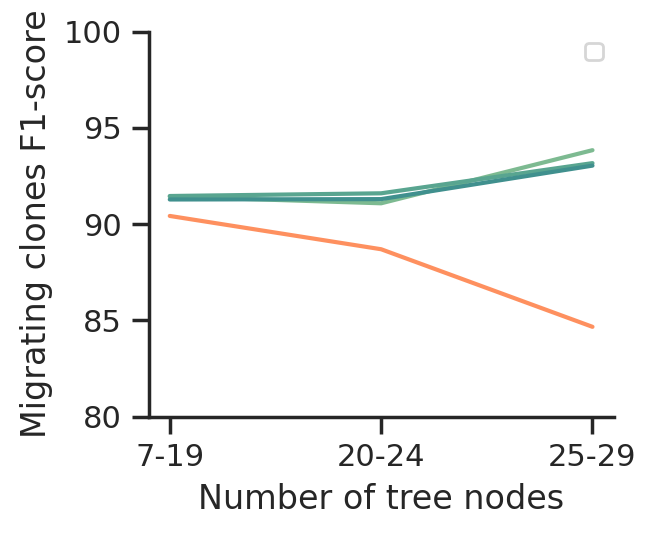

10:02:28 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 7 19 567
1 20 24 542
2 25 29 538


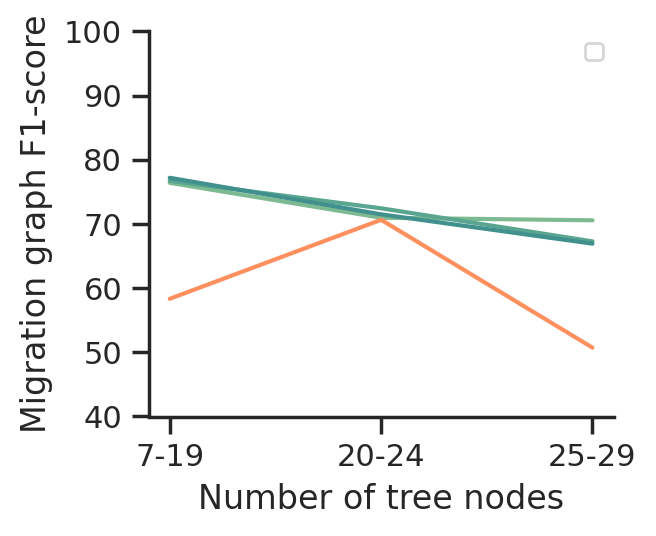

10:02:28 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 7 19 567
1 20 24 542
2 25 29 538


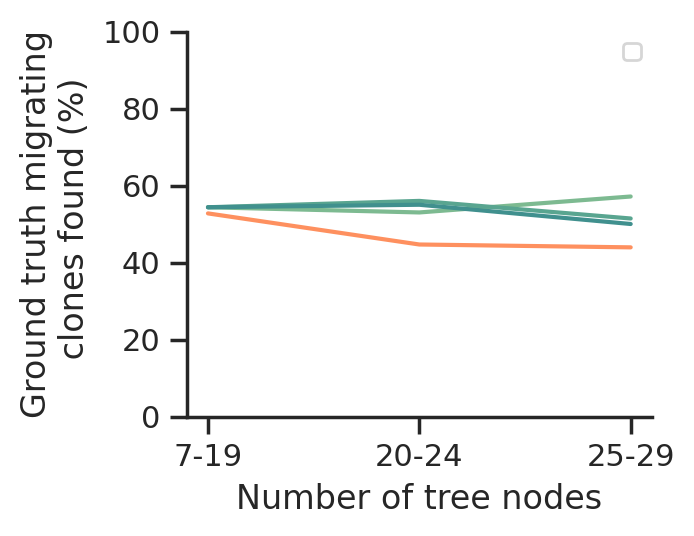

10:02:28 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 7 19 567
1 20 24 542
2 25 29 538


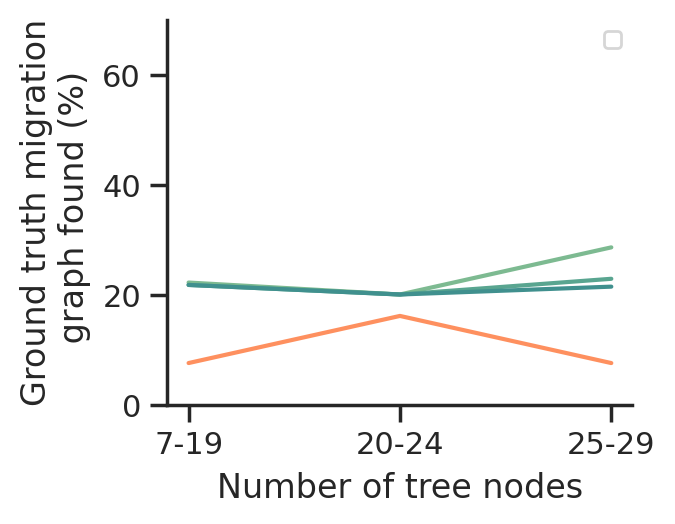

10:02:29 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 1.6e+04 1.8e+16 567
1 1.3e+17 8.9e+21 548
2 3.8e+22 1.4e+29 532


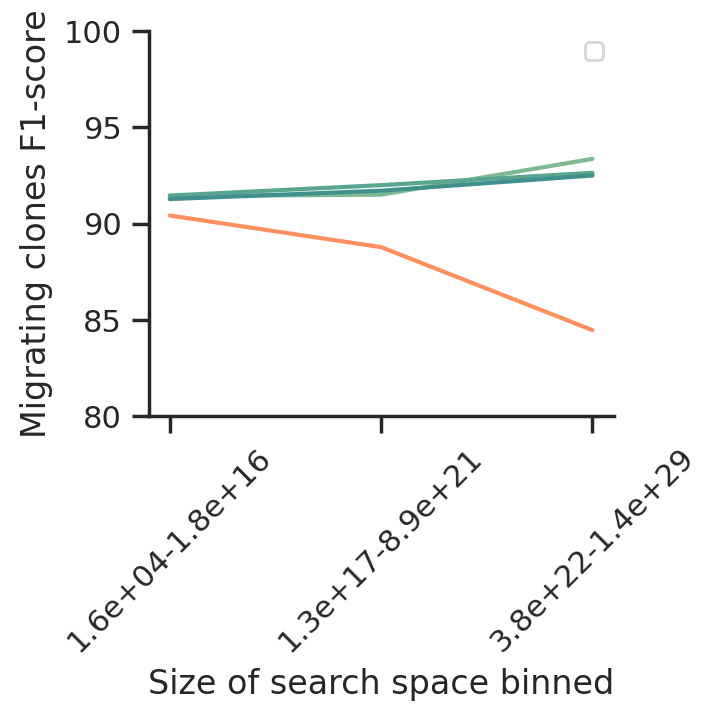

10:02:29 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 1.6e+04 1.8e+16 567
1 1.3e+17 8.9e+21 548
2 3.8e+22 1.4e+29 532


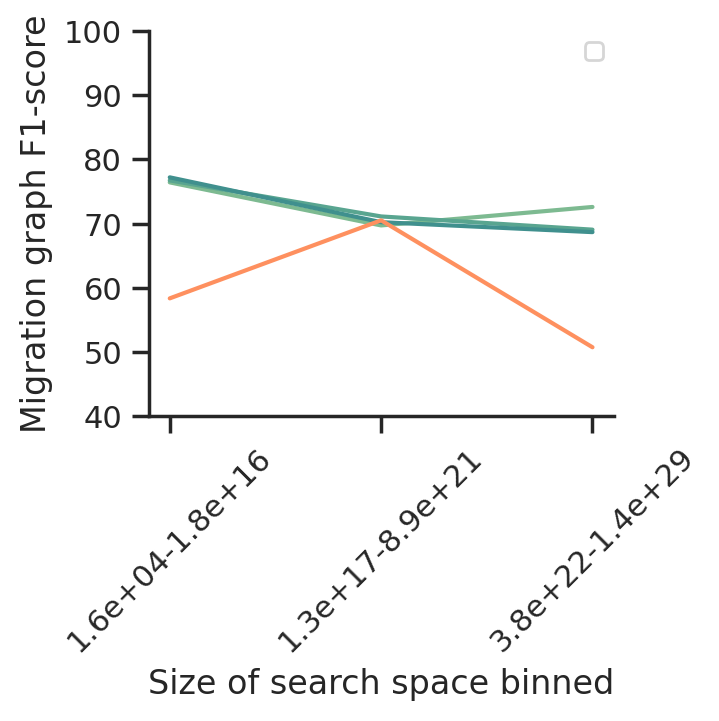

10:02:30 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 1.6e+04 1.8e+16 567
1 1.3e+17 8.9e+21 548
2 3.8e+22 1.4e+29 532


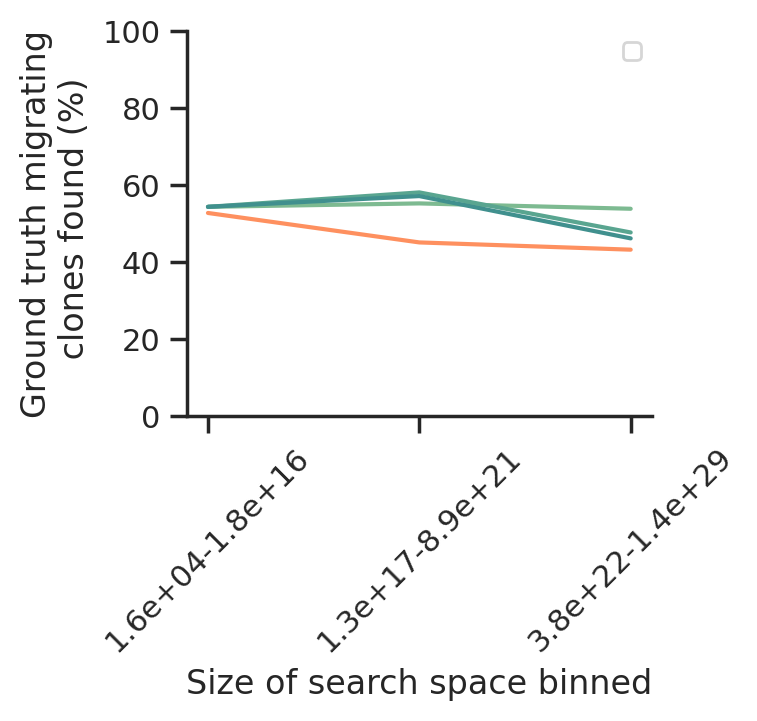

10:02:30 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 1.6e+04 1.8e+16 567
1 1.3e+17 8.9e+21 548
2 3.8e+22 1.4e+29 532


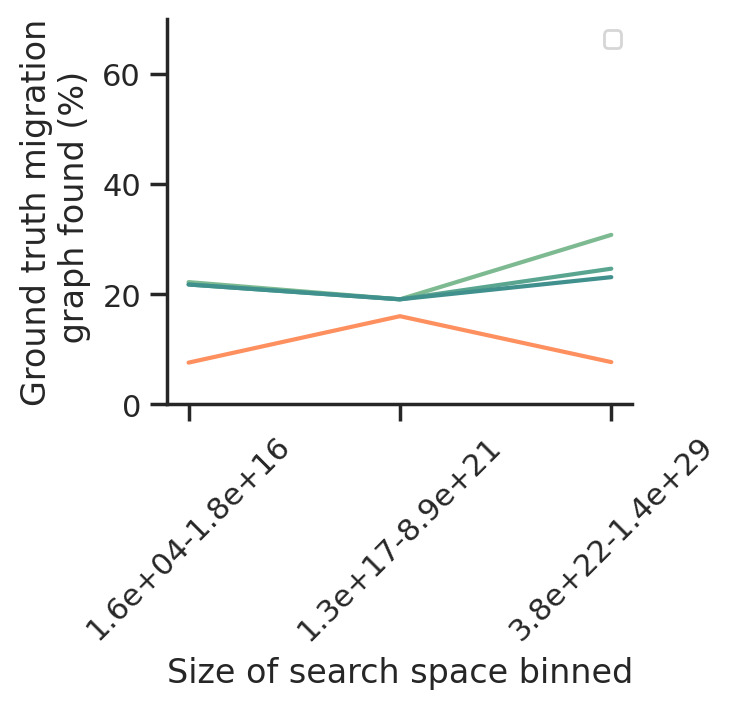

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("crest")
colors = colors[:len(methods)]
colors.append((0.99609375, 0.56640625, 0.37109375))
print(colors)


ys = ["Migrating clones F1-score", "Migration graph F1-score", "% time that migrating clone ground truth found", "% time that migration graph ground truth found"]
y_labels = ["Migrating clones F1-score", "Migration graph F1-score", "Ground truth migrating\n clones found (%)", "Ground truth migration\n graph found (%)"]
out_names = ["Migrating clones F1-score", "Migration graph F1-score", "Ground truth migrating clones found", "Ground truth migration graph found"]

def get_tree_node_bins():
    bin_numbers = sorted(list(cluster_num_df['cluster_bins'].unique()))
    bin_ranges = []
    for bin_num in bin_numbers:
        bin_min = cluster_num_df[cluster_num_df['cluster_bins']==bin_num]['clusters'].min()
        bin_max = cluster_num_df[cluster_num_df['cluster_bins']==bin_num]['clusters'].max()
        size = len(cluster_num_df[cluster_num_df['cluster_bins']==bin_num])
        bin_ranges.append(f"{bin_min}-{bin_max}")
        print(bin_num, bin_min, bin_max, size)
    return bin_numbers, bin_ranges

def get_prob_size_bins():
    bin_numbers = sorted(list(cluster_num_df['prob_size_bins'].unique()))
    bin_ranges = []
    for bin_num in bin_numbers:
        bin_min = cluster_num_df[cluster_num_df['prob_size_bins']==bin_num]['prob_size'].min()*denom
        bin_minf = "{:.1e}".format(bin_min)
        bin_max = cluster_num_df[cluster_num_df['prob_size_bins']==bin_num]['prob_size'].max()*denom
        bin_maxf = "{:.1e}".format(bin_max)
        size = len(cluster_num_df[cluster_num_df['prob_size_bins']==bin_num])
        bin_ranges.append(f"{bin_minf}-{bin_maxf}")
        print(bin_num, bin_minf, bin_maxf, size)
    return bin_numbers, bin_ranges

for x, df in zip(["Number of tree nodes", "Size of search space binned"], [results1, results3]):
    for i,y in enumerate(ys):
        plt.figure(figsize=(3, 2.5), dpi=200)
        sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.1})
        sns.set_palette(sns.color_palette(colors))
        with sns.plotting_context("notebook", font_scale=1.0):
            g = sns.lineplot(
                data=df, x=x, y=y, linewidth=1.5,
                hue="Method", legend=False,  
            )
            if x == "Number of tree nodes":
                bin_numbers, bin_ranges = get_tree_node_bins()
                plt.xticks(ticks=bin_numbers,labels=bin_ranges)
            if x == "Size of search space binned":
                bin_numbers, bin_ranges = get_prob_size_bins()
                plt.xticks(ticks=bin_numbers,labels=bin_ranges)
                plt.xticks(rotation=45)
            if x == "Size of search space":
                plt.xscale('log')
            
            if y == "% time that migration graph ground truth found":
                plt.ylim(0, 70)
            elif y == "Migrating clones F1-score":
                plt.ylim(80, 100)
            elif y == "Migration graph F1-score":
                plt.ylim(40, 100)
            else:
                plt.ylim(0, 100)
                
            legend = g.legend(prop={'size': 8})  # Set the desired font size here
            g.spines['top'].set_visible(False)
            g.spines['right'].set_visible(False)
            
            plt.ylabel(y_labels[i])
            out_name = ("_").join(out_names[i].split(" ") + x.split(" "))

            plt.savefig(os.path.join(REPO_DIR, "test/output_plots", f"{out_name}_10runs_lossthres{LOSS_THRES}_k{k}_{PARAMS}_{DATE}.png"), dpi=600, bbox_inches="tight", pad_inches=0.3) 

            plt.show()


In [9]:
import pandas as pd
data = []
for bs in bs_to_prob_size_to_ground_truth_slns:
    for search_size in bs_to_prob_size_to_ground_truth_slns[bs]:
        bs_ss_data = bs_to_prob_size_to_ground_truth_slns[bs][search_size]
        for item in bs_ss_data:
            data.append([bs, search_size, item[2], item[3]])
ss_df = pd.DataFrame(data, columns=["Batch size", "Search space size", "Migrating clones F1", "Migration graph F1"])
ss_df.to_csv("sample_size_exp_search_space_size.csv")


In [10]:
mach_data = []
for search_size in mach_prob_size_to_ground_truth_slns:
    items = mach_prob_size_to_ground_truth_slns[search_size]
    for item in items:
        mach_data.append({"Method": "MACHINA", "Search space size":search_size, "Migrating clones F1":item[2], "Migration graph F1":item[3]})
                 

In [11]:
import pandas as pd
import numpy as np

ss_df = pd.read_csv("sample_size_exp_search_space_size.csv")
ss_df['Method'] = ss_df.apply(lambda row: f"Metient-{int(row['Batch size'])}", axis=1)
ss_df = ss_df.loc[:, ~ss_df.columns.str.contains('^Unnamed')]
ss_df = ss_df.loc[:, ~ss_df.columns.str.contains('Batch size')]
ss_df = ss_df.append(mach_data, ignore_index=True)
ss_df['log(Search space size)'] = ss_df.apply(lambda row: np.log(row['Search space size']), axis=1)
ss_df

,Search space size,Migrating clones F1,Migration graph F1,Method,log(Search space size)
0,"381,469,726.562",1.000,1.000,Metient-64,19.760
1,"381,469,726.562",0.889,0.667,Metient-64,19.760
2,"381,469,726.562",1.000,1.000,Metient-64,19.760
3,"381,469,726.562",0.889,0.667,Metient-64,19.760
4,"381,469,726.562",1.000,1.000,Metient-64,19.760
...,...,...,...,...,...
2164,"30,223,145,490,365,730,816.000",0.889,1.000,MACHINA,44.855
2165,"30,223,145,490,365,730,816.000",1.000,1.000,MACHINA,44.855
2166,"30,223,145,490,365,730,816.000",0.889,1.000,MACHINA,44.855
2167,"30,223,145,490,365,730,816.000",1.000,1.000,MACHINA,44.855


[(0.99609375, 0.56640625, 0.37109375), (0.24929311, 0.56486397, 0.5586654)]


09:11:49 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


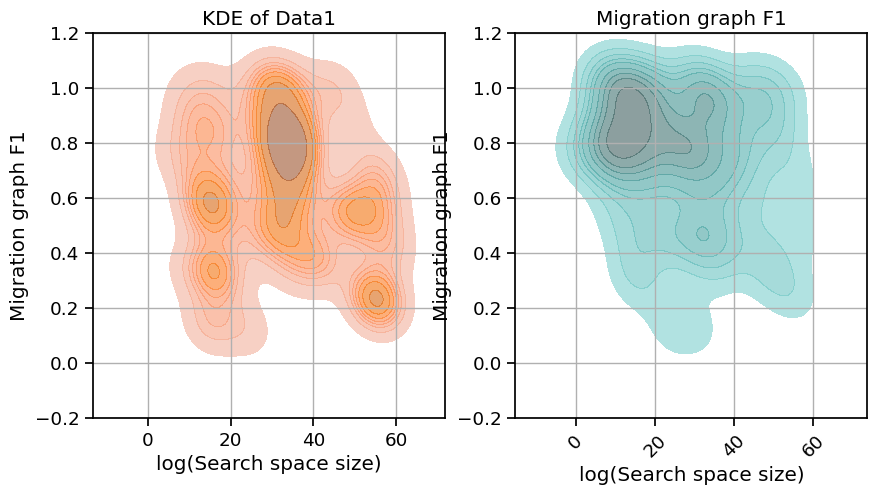

[(0.99609375, 0.56640625, 0.37109375), (0.24929311, 0.56486397, 0.5586654)]


09:11:51 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


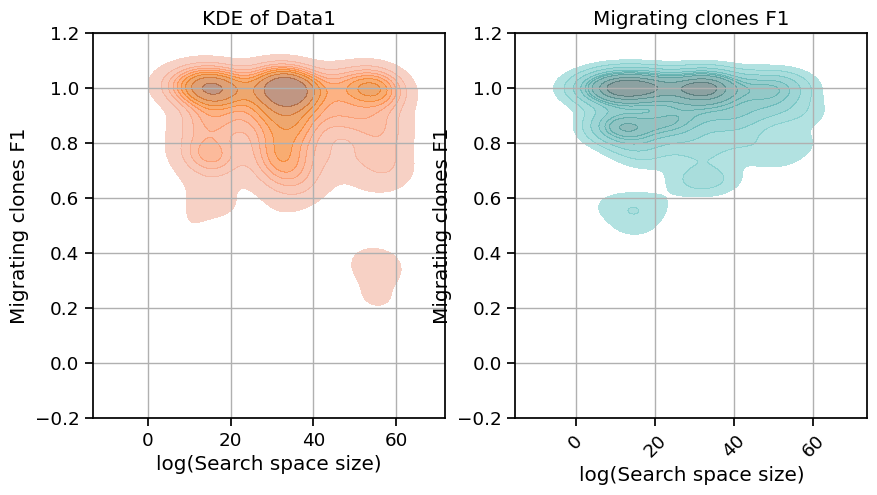

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def contour_plot(y):
    subset_df = ss_df[ss_df['Method'].isin(["MACHINA", "Metient-1024"])]
    colors = sns.color_palette("crest")
    colors = [colors[2]]
    colors.append((0.99609375, 0.56640625, 0.37109375))
    colors.reverse()
    print(colors)
    with sns.plotting_context("notebook", font_scale=1.2):
        # Plot using seaborn
        sns.set_palette(sns.color_palette(colors))
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot KDE plots
        sns.kdeplot(data=subset_df[subset_df['Method']=="MACHINA"], x='log(Search space size)', 
                    y=y, ax=axs[0], color=colors[0], fill=True, alpha=0.6,)
        sns.kdeplot(data=subset_df[subset_df['Method']=="Metient-1024"], x='log(Search space size)', 
                    y=y, ax=axs[1], color=colors[1], fill=True, alpha=0.6,)

        # Add a grid to each subplot
        axs[0].grid(True)
        axs[1].grid(True)

        # Optionally, set titles for each subplot
        axs[0].set_title('KDE of Data1')
        axs[1].set_title('KDE of Data2')
        axs[0].set_ylim(-0.2,1.2)
        axs[1].set_ylim(-0.2,1.2)

#         plt.figure(figsize=(2, 2), dpi=300) 
#         g = sns.kdeplot(data=subset_df, x='log(Search space size)', 
#                             y=y,hue='Method',legend=True,hue_order=["MACHINA", "Metient-1024"],
#                             palette=colors,fill=True, alpha=0.6,linewidths=1.8)

    #     g = sns.scatterplot(data=ss_df, x='log(Search space size)', 
    #                         y='Migrating clones F1',hue='Method',
    #                         palette=colors, s=100, )  # s is the marker size
        #legend = g.legend(prop={'size': 8})  # Set the desired font size here

        g.spines['top'].set_visible(False)
        g.spines['right'].set_visible(False)
        plt.legend(loc='center left',frameon=False)


        # Optional: additional plot styling
        plt.title(y)
        plt.xticks(rotation=45)  # Rotates x-axis labels to avoid overlap
        #plt.subplots_adjust(right=0.75)  # Adjust this value as needed to make space for the legend

        # Show the plot
        plt.show()
    
contour_plot('Migration graph F1')
contour_plot('Migrating clones F1')